In [1]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [2]:
from imports import *

## Tests lr 

### uncased

#### testing

In [3]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [4]:
bs = 32
bs_val = 128
max_length=200
agg = 'mean'
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

In [ ]:
tr_ds = TextDS(train_df, tokenizer, max_length=max_length)
val_ds = TextDS(val_df, tokenizer, max_length=max_length)
full_ds = TextDS(df, tokenizer, max_length=max_length)

In [ ]:
torch.save(tr_ds, 'data/text_models/datasets/tr_ds_0.3_{}.pth'.format(max_length))
torch.save(val_ds, 'data/text_models/datasets/val_ds_0.3_{}.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/full_ds_0.3_{}.pth'.format(max_length))

In [5]:
tr_ds = torch.load('data/text_models/datasets/tr_ds_0.3_{}.pth'.format(max_length))
val_ds = torch.load('data/text_models/datasets/val_ds_0.3_{}.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/full_ds_0.3_{}.pth'.format(max_length))

In [6]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
#full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
# model
model = EMBBert(language_model, agg=agg).to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [8]:
centers = torch.load('data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [9]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [10]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [11]:
unfreeze_bert_to(model, 10)

Unfroze 32 parameters


In [12]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/test_12ap_epochs'

In [13]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_0.pth


Saved best model ep 0 with f score : 0.6134224358446186
Ep 0: Train loss 9.9623 | Val f score 0.6134 with thresh 0.73, train f score 0.5879 with thresh 0.73


Saved best model ep 1 with f score : 0.6403566809792569
Ep 1: Train loss 8.4241 | Val f score 0.6404 with thresh 0.73, train f score 0.6738 with thresh 0.83


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_2.pth


Saved best model ep 2 with f score : 0.655571273586006
Ep 2: Train loss 5.8388 | Val f score 0.6556 with thresh 0.78, train f score 0.7725 with thresh 0.93


Saved best model ep 3 with f score : 0.6628752112823555
Ep 3: Train loss 3.6691 | Val f score 0.6629 with thresh 0.83, train f score 0.8363 with thresh 0.93


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_4.pth


Saved best model ep 4 with f score : 0.66618577123748
Ep 4: Train loss 2.5325 | Val f score 0.6662 with thresh 0.83, train f score 0.8756 with thresh 0.93


In [14]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-4, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [15]:
unfreeze_bert_to(model, 6)

Unfroze 96 parameters


In [16]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 5 with f score : 0.6691313062397024
Ep 5: Train loss 2.6464 | Val f score 0.6691 with thresh 0.83, train f score 0.8754 with thresh 0.93


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_6.pth


Saved best model ep 6 with f score : 0.672848153774134
Ep 6: Train loss 1.9609 | Val f score 0.6728 with thresh 0.83, train f score 0.9053 with thresh 0.93


In [17]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [18]:
unfreeze(model)

In [19]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Saved best model ep 7 with f score : 0.6760731523704145
Ep 7: Train loss 1.5734 | Val f score 0.6761 with thresh 0.83, train f score 0.9226 with thresh 0.93


Checkpoint : saved model to data/text_models/test_12ap_epochs_ep_8.pth


Ep 8: Train loss 1.3791 | Val f score 0.6760 with thresh 0.83, train f score 0.9332 with thresh 0.93


In [21]:
def plot_hist(history) : 
    train_scores = [info['train']['f1'] for info in history]
    train_thr = [info['train']['thr'] for info in history]
    val_scores = [info['val']['f1'] for info in history]
    val_thr = [info['val']['thr'] for info in history]
    x = range(len(train_scores))
    plt.plot(x, val_scores, label='val_score')
    plt.plot(x, train_scores, label='train_score')
    plt.legend()
    plt.show()
    plt.plot(x, val_thr, label='val_thr')
    plt.plot(x, train_thr, label='train_thr')
    plt.legend()
    plt.show()

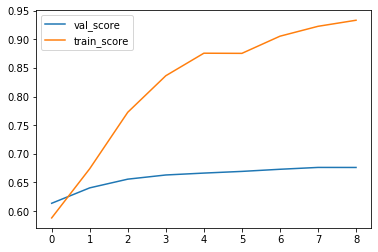

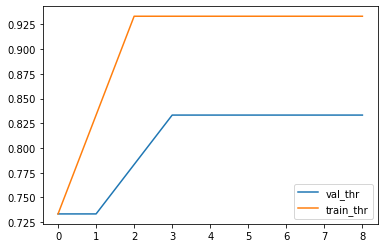

In [22]:
plot_hist(thr_score_hist)

#### full train

In [23]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [24]:
from imports import *

In [25]:
def plot_hist(history) : 
    train_scores = [info['train']['f1'] for info in history]
    train_thr = [info['train']['thr'] for info in history]
    val_scores = [info['val']['f1'] for info in history]
    val_thr = [info['val']['thr'] for info in history]
    x = range(len(train_scores))
    plt.plot(x, val_scores, label='val_score')
    plt.plot(x, train_scores, label='train_score')
    plt.legend()
    plt.show()
    plt.plot(x, val_thr, label='val_thr')
    plt.plot(x, train_thr, label='train_thr')
    plt.legend()
    plt.show()

In [26]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=1)

In [27]:
bs = 32
bs_val = 128
max_length=200
agg = 'mean'
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

tr_ds = TextDS(train_df, tokenizer, max_length=max_length)
full_ds = TextDS(df, tokenizer, max_length=max_length)

torch.save(tr_ds, 'data/text_models/datasets/tr_ds_full_{}.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/full_ds_full_{}.pth'.format(max_length))

In [32]:
tr_ds = torch.load('data/text_models/datasets/tr_ds_full_{}.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/full_ds_full_{}.pth'.format(max_length))

In [33]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs_val, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
#full_dl = DataLoader(full_ds, batch_size = bs_val, shuffle = False, pin_memory = True)

In [7]:
model = EMBBert(language_model).to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_full.pth')

In [10]:
centers = torch.load('data/text_models/centers_full.pth')

In [11]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [10]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [11]:
unfreeze_bert_to(model, 10)

Unfroze 32 parameters


In [13]:
loss_hist = []
best_thr_score={'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/2april'

In [13]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 11.4460 | F score 0.5088 with thresh 0.64


Ep 1: Loss 10.1777 | F score 0.5531 with thresh 0.74


Checkpoint : saved model to data/text_models/2april_ep_2.pth
Ep 2: Loss 7.6275 | F score 0.6458 with thresh 0.84


Ep 3: Loss 5.2639 | F score 0.7408 with thresh 0.94


Checkpoint : saved model to data/text_models/2april_ep_4.pth
Ep 4: Loss 3.8014 | F score 0.7810 with thresh 0.94


torch.save(metric_fc.state_dict(), save_path+'_met_1fr.pth')

In [12]:
metric_fc.load_state_dict(torch.load(save_path+'_met_1fr.pth'))

<All keys matched successfully>

In [13]:
model.load_state_dict(torch.load('data/text_models/2april_ep_4.pth'))

<All keys matched successfully>

In [14]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-4, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [15]:
freeze(model)
unfreeze_bert_to(model, 6)

Unfroze 96 parameters


In [16]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 3.9497 | F score 0.7760 with thresh 0.91


Ep 1: Loss 3.1694 | F score 0.8175 with thresh 0.96


torch.save(metric_fc.state_dict(), save_path+'_met_3fr.pth')
torch.save(model.state_dict(), save_path+'_mod_3fr.pth')

In [14]:
model.load_state_dict(torch.load(save_path+'_mod_3fr.pth'))
metric_fc.load_state_dict(torch.load(save_path+'_met_3fr.pth'))

<All keys matched successfully>

In [15]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=1e-5, n_epochs=2)
freeze_bert_embeddings(model)
freeze(model)

Unfroze 5 parameters


In [16]:
unfreeze(model)

In [17]:
best_thr_score, thr_score_hist, losses = train_full_data(model, optimizer, lf, sched, metric_fc, tr_dl,
                                               n_epochs, train_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/2april_ep_0.pth
Ep 0: Loss 2.6738 | F score 0.8324 with thresh 0.91


Ep 1: Loss 2.3517 | F score 0.8514 with thresh 0.96


In [2]:
from imports import *

### cased

In [3]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [6]:
bs = 64
max_length=40
agg = 'mean'
language_model = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(language_model)

tr_ds = TextDS(train_df, tokenizer, max_length=40)
val_ds = TextDS(val_df, tokenizer, max_length=40)
full_ds = TextDS(df, tokenizer, max_length=40)

torch.save(tr_ds, 'data/text_models/datasets/tr_ds_0.3_{}.pth'.format(max_length))
torch.save(val_ds, 'data/text_models/datasets/val_ds_0.3_{}.pth'.format(max_length))
torch.save(full_ds, 'data/text_models/datasets/full_ds_0.3_{}.pth'.format(max_length))

In [7]:
tr_ds = torch.load('data/text_models/datasets/tr_ds_0.3_{}.pth'.format(max_length))
val_ds = torch.load('data/text_models/datasets/val_ds_0.3_{}.pth'.format(max_length))
full_ds = torch.load('data/text_models/datasets/full_ds_0.3_{}.pth'.format(max_length))

In [8]:
tr_test_dl = DataLoader(tr_ds, batch_size = bs, shuffle = False, pin_memory = True)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, pin_memory = True)
full_dl = DataLoader(full_ds, batch_size = bs, shuffle = False, pin_memory = True)

In [9]:
# model
model = EMBBert(language_model, agg=agg).to(device)

In [10]:
centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [11]:
centers = torch.load('data/text_models/centers_0.3_{}_{}_{}.pth'.format(agg, max_length, language_model))

In [12]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [13]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=10, sched=True)

In [14]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/test_3n_epochs'

In [15]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, sched, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/test_3n_epochs_ep_0.pth


Saved best model ep 0 with f score : 0.6189773403340896
Ep 0: Train loss 10.9619 | Val f score 0.6190 with thresh 0.73, train f score 0.6182 with thresh 0.82


KeyboardInterrupt: 

### cls agg

In [3]:
from utils import compute_f1, load_data
from text_train.imports import *
from text_train.data import TextDS, text_to_device
from arcface import ArcMarginProduct
from text_train.model import EMBBert
from text_train.train import *
np.random.seed(1337)
device = torch.device('cuda')

In [4]:
from imports import *

In [5]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [6]:
bs = 64
language_model = 'bert-base-multilingual-uncased'
tokenizer = BertTokenizer.from_pretrained(language_model)

tr_ds = TextDS(train_df, tokenizer)
tr_test_dl = DataLoader(tr_ds, batch_size = bs, shuffle = False, pin_memory = True)

tr_ds = TextDS(train_df, tokenizer)
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, pin_memory = True)

val_ds = TextDS(val_df, tokenizer)
val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, pin_memory = True)

full_ds = TextDS(df, tokenizer)
full_dl = DataLoader(full_ds, batch_size = bs, shuffle = False, pin_memory = True)

torch.save(tr_test_dl, 'data/text_models/tr_test_dl_0.3.pth')
torch.save(tr_dl, 'data/text_models/tr_dl_0.3.pth')
torch.save(val_dl, 'data/text_models/val_dl_0.3.pth')
torch.save(full_dl, 'data/text_models/full_dl_0.3.pth')

In [7]:
tr_dl = torch.load('data/text_models/tr_dl_0.3.pth')
val_dl = torch.load('data/text_models/val_dl_0.3.pth')
tr_test_dl = torch.load('data/text_models/tr_test_dl_0.3.pth')
full_dl = torch.load('data/text_models/full_dl_0.3.pth')

In [8]:
# model
model = EMBBert(language_model, agg='cls').to(device)

centers = compute_centers(tr_test_dl, model, train_df)
torch.save(centers, 'data/text_models/centers_0.3.pth')

In [9]:
centers = torch.load('data/text_models/centers_0.3.pth')

In [10]:
metric_fc = ArcMarginProduct(512, train_df['label_group'].nunique(), s=30, m=0.5,
                             easy_margin=False, centers=centers, device=device).to(device)

Using center as wieghts


In [11]:
n_epochs, lf, params, optimizer, sched = get_hparams(tr_dl, model, metric_fc, lr=5e-4, n_epochs=5, sched=None)

In [12]:
loss_hist = []
best_thr_score={'val': {'thr': None, 'f1': None}, 'train': {'thr': None, 'f1': None}}
thr_score_hist=[]
ep_start = 0
save_path = 'data/text_models/test_3n_epochs'

In [13]:
best_thr_score, thr_score_hist, losses = train(model, optimizer, lf, None, metric_fc, tr_dl, val_dl,
                                               n_epochs, train_df, val_df, 
                                               save_path=save_path, 
                                               prev_best_info=best_thr_score, info_history=thr_score_hist,
                                               ep_start=ep_start, device=device)
loss_hist.append(losses)
ep_start += n_epochs

Checkpoint : saved model to data/text_models/test_3n_epochs_ep_0.pth


Saved best model ep 0 with f score : 0.0003401704083750586
Ep 0: Train loss 15.8120 | Val f score 0.0003 with thresh 0.20, train f score 0.4530 with thresh 0.20


KeyboardInterrupt: 

## Translate

In [3]:
df, train_df, val_df, train_labels, val_labels = load_data(train_perc=0.3)

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("../input/id-en-converter")
txt_model = AutoModelForSeq2SeqLM.from_pretrained("../input/id-en-converter")

In [7]:
#tokenizer = AutoTokenizer.from_pretrained("../id-en-converter")
txt_model = AutoModelForSeq2SeqLM.from_pretrained("../input/id-en-converter")

404 Client Error: Not Found for url: https://huggingface.co/input/id-en-converter/resolve/main/config.json


OSError: Can't load config for '../input/id-en-converter'. Make sure that:

- '../input/id-en-converter' is a correct model identifier listed on 'https://huggingface.co/models'

- or '../input/id-en-converter' is the correct path to a directory containing a config.json file

